Your Own Analysis 2 
GOAL
1) Lin28a CLIP-seq Binding 위치 주석 (CDS, UTR)
2) CLIP-enrichment, RNA_Change, Rden_change 계산
3) Enrichment 대비 mRNA-abundance 변화 visualization (scatter plot w/ pearsonr)
4) Enrichment 대비 Ribosome density change 변화 visualization (scatter plot w/ pearsonr)
5) CDS-bound, UTR-bound gene 중, CLIP-enrichment 값이 특정 cutoff 이상인 것에 대한 Gene Ontology 분석


1. Lin28a CLIP-seq Binding 위치 주석 (CDS, UTR)

In [2]:
import os
os.chdir("/home/sohyunkum2/binfo/YOA/data")

#!bedtools bamtobed -i CLIP-35L33G.bam > CLIP-35L33G.bed

In [2]:
import pandas as pd

df = pd.read_csv("CLIP-35L33G.bed", sep="\t", header=None)
df["length"] = df[2] - df[1]
df["length"].describe()

## 대부분의 CLIP-tag이 정상범주이지만, 확실히 이상치가 존재함. filtering 필요

count    3.658978e+07
mean     3.331180e+02
std      3.760625e+03
min      1.000000e+01
25%      2.800000e+01
50%      3.600000e+01
75%      4.700000e+01
max      2.831640e+05
Name: length, dtype: float64

In [ ]:
!awk '{ if ($3 - $2 >= 20 && $3 - $2 <= 60) print $0 }' CLIP-35L33G.bed > CLIP-35L33G.filtered.bed

In [ ]:
df = pd.read_csv("CLIP-35L33G.filtered.bed", sep="\t", header=None)
df["length"] = df[2] - df[1]
df["length"].describe()

## CLIP-tag의 길이가 정상범주 안에 들어오는 것으로 잘 filtering 된 것을 확인할 수 있음

count    3.185128e+07
mean     3.570113e+01
std      1.016305e+01
min      2.000000e+01
25%      2.700000e+01
50%      3.500000e+01
75%      4.300000e+01
max      6.000000e+01
Name: length, dtype: float64

In [ ]:
# GTF 파일에서 CDS와 UTR 영역 추출
!awk '$3 == "CDS"' gencode.gtf > CDS.gtf
!awk '$3 =="UTR"' gencode.gtf > utr.gtf

In [27]:
# GTF -> BED 변환 (Intersect 하기 위함)
!gtf2bed < CDS.gtf > CDS.bed
!gtf2bed < utr.gtf > utr.bed

In [ ]:
# Binding 위치와 CDS/3'UTR intersect 
!bedtools intersect -a CLIP-35L33G.bed -b CDS.bed -wa -wb > binding_in_CDS.bed_3
!bedtools intersect -a CLIP-35L33G.bed -b utr.bed -wa -wb > binding_in_UTR.bed_3

***** WARNING: File CLIP-35L33G.bed has inconsistent naming convention for record:
GL456210.1	7142	7157	SRR458758.6758016	40	-

***** WARNING: File CLIP-35L33G.bed has inconsistent naming convention for record:
GL456210.1	7142	7157	SRR458758.6758016	40	-

***** WARNING: File CLIP-35L33G.bed has inconsistent naming convention for record:
GL456210.1	7142	7157	SRR458758.6758016	40	-

***** WARNING: File CLIP-35L33G.bed has inconsistent naming convention for record:
GL456210.1	7142	7157	SRR458758.6758016	40	-



In [6]:
# pandas로 상위 몇 줄 확인
import pandas as pd

cds = pd.read_csv("binding_in_CDS.bed_3", sep="\t", header=None)
cds.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,chr1,4415710,4415731,SRR458758.17471422,40,+,chr1,4414825,4420314,ENSMUSG00000025900.14,.,-,HAVANA,CDS,2,"gene_id ""ENSMUSG00000025900.14""; transcript_id..."
1,chr1,4415710,4415731,SRR458758.28054338,39,+,chr1,4414825,4420314,ENSMUSG00000025900.14,.,-,HAVANA,CDS,2,"gene_id ""ENSMUSG00000025900.14""; transcript_id..."
2,chr1,4416338,4416361,SRR458758.364793,3,-,chr1,4414825,4420314,ENSMUSG00000025900.14,.,-,HAVANA,CDS,2,"gene_id ""ENSMUSG00000025900.14""; transcript_id..."
3,chr1,4416338,4416361,SRR458758.6412856,2,-,chr1,4414825,4420314,ENSMUSG00000025900.14,.,-,HAVANA,CDS,2,"gene_id ""ENSMUSG00000025900.14""; transcript_id..."
4,chr1,4416338,4416361,SRR458758.7312889,1,-,chr1,4414825,4420314,ENSMUSG00000025900.14,.,-,HAVANA,CDS,2,"gene_id ""ENSMUSG00000025900.14""; transcript_id..."


In [15]:
import pandas as pd

# 1. CLIP-tag BED 파일 읽기
cds = pd.read_csv("binding_in_CDS.bed_3", sep="\t", header=None)
utr = pd.read_csv("binding_in_UTR.bed_3", sep="\t", header=None)

# 2. GTF 정보가 담긴 마지막 컬럼에서 gene_id 추출
def extract_gene_id(col):
    return col.str.extract(r'gene_id "([^"]+)"')[0]

cds['gene_id'] = extract_gene_id(cds[15].astype(str))
utr['gene_id'] = extract_gene_id(utr[15].astype(str))

# 3. transcript별 CLIP-tag 개수 세기
cds_count = cds['gene_id'].value_counts().rename("cds_tag_count")
utr_count = utr['gene_id'].value_counts().rename("utr_tag_count")

# 4. 두 count 테이블 합치기
tag_df = pd.concat([cds_count, utr_count], axis=1).fillna(0)

# 5. transcript 분류 기준 적용
def classify_binding(row):
    cds = row["cds_tag_count"]
    utr = row["utr_tag_count"]
    if cds > 1.5 * utr:
        return "CDS-bound"
    elif utr > 1.5 * cds:
        return "UTR-bound"
    elif cds == 0 and utr == 0:
        return "none"
    else:
        return "ambiguous"

tag_df["binding_type"] = tag_df.apply(classify_binding, axis=1)

# 6. 결과 저장
tag_df.to_csv("transcript_binding_annotation.txt", sep="\t")

# 확인용 출력
print(tag_df["binding_type"].value_counts())


binding_type
UTR-bound    7545
CDS-bound    6570
ambiguous    3020
Name: count, dtype: int64


In [ ]:

import pandas as pd
import numpy as np

# 1) 파일 읽기 (이미 해 두셨다고 가정)
counts = pd.read_csv(
    "read-counts.txt",
    sep=r"\s+",
    engine="python",
    comment="#",
    header=0,
    index_col=0
)

# 2) 순수 count 열만 선택
count_cols = [c for c in counts.columns if c.endswith('.bam')]
counts_only = counts[count_cols].apply(pd.to_numeric, errors='raise')
length_nt = counts['Length']
length_kb = length_nt / 1e3

# 3) lib_sizes 계산
lib_sizes = counts_only.sum(axis=0)
lib_millions = lib_sizes / 1e6

# 4) RPKM 계산
#    RPKM = raw_count / (length_kb * lib_millions)
rpkm = counts_only.div(length_kb, axis=0).div(lib_millions, axis=1)

# ————————————————
# 4-1) RNA stability 분석용: RNA-seq ≥ 30
mask_rna = (
    (counts_only['RNA-siLin28a.bam'] >= 30) &
    (counts_only['RNA-siLuc.bam'] >= 30) &
    (counts_only['RNA-control.bam'] >= 30)
)
rpkm_rna = rpkm.loc[mask_rna, :]   # 필터링된 전사체만

# 4-2) RPKM 파일로 저장 (RNA용)
rpkm_rna.to_csv("rpkm_RNA_filtered.txt", sep="\t", index=True, header=True)

# 5-1) Ribosome density 분석용 필터링
mask_ribo = (
    (counts_only['RNA-siLin28a.bam'] >= 30) &
    (counts_only['RNA-siLuc.bam'] >= 30) &
    (counts_only['RNA-control.bam'] >= 30) &
    (counts_only['RPF-siLuc.bam'] >= 80)
)
rpkm_ribo = rpkm.loc[mask_ribo, :]

# 5-2) RPKM 파일로 저장 (Ribo용)
rpkm_ribo.to_csv("rpkm_Ribo_filtered.txt", sep="\t", index=True, header=True)


# 6) (선택) 정상 적용 확인
print("RNA용 전사체 수:", rpkm_rna.shape[0])
print("Ribo용 전사체 수:", rpkm_ribo.shape[0])
print(rpkm_rna.head())
print(rpkm_ribo.head())

RNA용 전사체 수: 10481
Ribo용 전사체 수: 7987
                       CLIP-35L33G.bam  RNA-control.bam  RNA-siLin28a.bam  \
Geneid                                                                      
ENSMUSG00000102343.2          3.603582         4.369927         12.299894   
ENSMUSG00000103922.2         12.558779        17.087272          7.050998   
ENSMUSG00000033845.14        34.697421        30.698131         28.859290   
ENSMUSG00000025903.15        20.997380        15.446728         13.827601   
ENSMUSG00000033813.16        40.316540        48.563111         57.220240   

                       RNA-siLuc.bam  RPF-siLin28a.bam  RPF-siLuc.bam  
Geneid                                                                 
ENSMUSG00000102343.2       11.806868          0.068555       0.113381  
ENSMUSG00000103922.2        9.595591          3.673879       5.425107  
ENSMUSG00000033845.14      30.977319         20.482286      29.073501  
ENSMUSG00000025903.15      17.744577          0.431882       0.4

#####  RPKM Normalization & binding type merge

1) RNA-abundance scatter plot 용 RPKM normalization

In [76]:
## CLIP-35L33G.bam / RNA-control.bam / RNA-siLin28a.bam / RNA-siLuc.bam / RPF-siLin28a.bam / RPF-siLuc.bam 파일의 count data 불러온 후 
## 위에 annotation 해 놓은 텍스트 파일과 병합 및 CDS/UTR binding이 아닌 경우에 "none"으로 주석 표시
import pandas as pd

# 1. count table 불러오기
counts_rna = pd.read_csv("rpkm_RNA_filtered.txt", sep="\t", index_col = 0, header=0)

print(counts_rna.head())
# 2. binding annotation 불러오기
binding = pd.read_csv("transcript_binding_annotation.txt", sep="\t", index_col=0)
binding.head()
# 3. 병합 (기준: gene_id가 index라고 가정)
merged = counts_rna.merge(binding[["binding_type"]], left_index=True, right_index=True, how="left")

# 4. binding_type이 없는 경우 → 'none'으로 채움
merged["binding_type"] = merged["binding_type"].fillna("none")

# 5. 확인
print(merged["binding_type"].value_counts())

# 6. 필요시 저장
merged.to_csv("read_counts_for_rna_change_with_binding_type.txt", sep="\t")


                       CLIP-35L33G.bam  RNA-control.bam  RNA-siLin28a.bam  \
Geneid                                                                      
ENSMUSG00000102343.2          3.603582         4.369927         12.299894   
ENSMUSG00000103922.2         12.558779        17.087272          7.050998   
ENSMUSG00000033845.14        34.697421        30.698131         28.859290   
ENSMUSG00000025903.15        20.997380        15.446728         13.827601   
ENSMUSG00000033813.16        40.316540        48.563111         57.220240   

                       RNA-siLuc.bam  RPF-siLin28a.bam  RPF-siLuc.bam  
Geneid                                                                 
ENSMUSG00000102343.2       11.806868          0.068555       0.113381  
ENSMUSG00000103922.2        9.595591          3.673879       5.425107  
ENSMUSG00000033845.14      30.977319         20.482286      29.073501  
ENSMUSG00000025903.15      17.744577          0.431882       0.476184  
ENSMUSG00000033813.16      7

In [77]:
import pandas as pd

# 1. count table 불러오기
counts_ribo = pd.read_csv("rpkm_Ribo_filtered.txt", sep="\t", index_col = 0, header=0)

print(counts_ribo.head())
# 2. binding annotation 불러오기
binding = pd.read_csv("transcript_binding_annotation.txt", sep="\t", index_col=0)
binding.head()

# 3. 병합 (기준: gene_id가 index라고 가정)
merged = counts_ribo.merge(binding[["binding_type"]], left_index=True, right_index=True, how="left")

# 4. binding_type이 없는 경우 → 'none'으로 채움
merged["binding_type"] = merged["binding_type"].fillna("none")

# 5. 확인
print(merged["binding_type"].value_counts())

# 6. 필요시 저장
merged.to_csv("read_counts_for_ribo_change_with_binding_type.txt", sep="\t")

                       CLIP-35L33G.bam  RNA-control.bam  RNA-siLin28a.bam  \
Geneid                                                                      
ENSMUSG00000033845.14        34.697421        30.698131         28.859290   
ENSMUSG00000033813.16        40.316540        48.563111         57.220240   
ENSMUSG00000033793.13         8.362992         9.351446         10.478268   
ENSMUSG00000025907.15         7.590945         3.664908          3.828980   
ENSMUSG00000051285.18        38.676826        15.286206         28.745812   

                       RNA-siLuc.bam  RPF-siLin28a.bam  RPF-siLuc.bam  
Geneid                                                                 
ENSMUSG00000033845.14      30.977319         20.482286      29.073501  
ENSMUSG00000033813.16      75.649162         10.166039      15.608699  
ENSMUSG00000033793.13      10.851298          5.785543       8.949678  
ENSMUSG00000025907.15       6.305440          0.840244       1.321225  
ENSMUSG00000051285.18      2

##### 1. RNA Abundance change visualization

In [196]:
## binding region 열 추가된 count data 확인
import pandas as pd

counts_with_binding_rna = pd.read_csv("read_counts_for_rna_change_with_binding_type.txt", sep="\t", comment="#", index_col=0)
counts_with_binding_rna.head()

,CLIP-35L33G.bam,RNA-control.bam,RNA-siLin28a.bam,RNA-siLuc.bam,RPF-siLin28a.bam,RPF-siLuc.bam,binding_type
Geneid,,,,,,,
ENSMUSG00000102343.2,3.603582,4.369927,12.299894,11.806868,0.068555,0.113381,none
ENSMUSG00000103922.2,12.558779,17.087272,7.050998,9.595591,3.673879,5.425107,none
ENSMUSG00000033845.14,34.697421,30.698131,28.859290,30.977319,20.482286,29.073501,CDS-bound
ENSMUSG00000025903.15,20.997380,15.446728,13.827601,17.744577,0.431882,0.476184,ambiguous
ENSMUSG00000033813.16,40.316540,48.563111,57.220240,75.649162,10.166039,15.608699,ambiguous


In [208]:
# read count data에 CLIP-enrichment, rden_change, RNA_change 열 추가

counts_with_binding_rna['clip_enrichment'] = (counts_with_binding_rna['CLIP-35L33G.bam']) / (counts_with_binding_rna['RNA-control.bam'])
counts_with_binding_rna['RNA_change'] = (counts_with_binding_rna['RNA-siLin28a.bam']) / (counts_with_binding_rna['RNA-siLuc.bam'])
counts_with_binding_rna.head()

,CLIP-35L33G.bam,RNA-control.bam,RNA-siLin28a.bam,RNA-siLuc.bam,RPF-siLin28a.bam,RPF-siLuc.bam,binding_type,clip_enrichment,RNA_change,clip_enrichment_log2,rna_change_log2
Geneid,,,,,,,,,,,
ENSMUSG00000102343.2,3.603582,4.369927,12.299894,11.806868,0.068555,0.113381,none,0.824632,1.041758,-0.276429,0.060404
ENSMUSG00000103922.2,12.558779,17.087272,7.050998,9.595591,3.673879,5.425107,none,0.734979,0.734817,-0.442264,-0.442582
ENSMUSG00000033845.14,34.697421,30.698131,28.859290,30.977319,20.482286,29.073501,CDS-bound,1.130278,0.931626,0.177953,-0.100629
ENSMUSG00000025903.15,20.997380,15.446728,13.827601,17.744577,0.431882,0.476184,ambiguous,1.359342,0.779258,0.443969,-0.357977
ENSMUSG00000033813.16,40.316540,48.563111,57.220240,75.649162,10.166039,15.608699,ambiguous,0.830189,0.756390,-0.266752,-0.400892


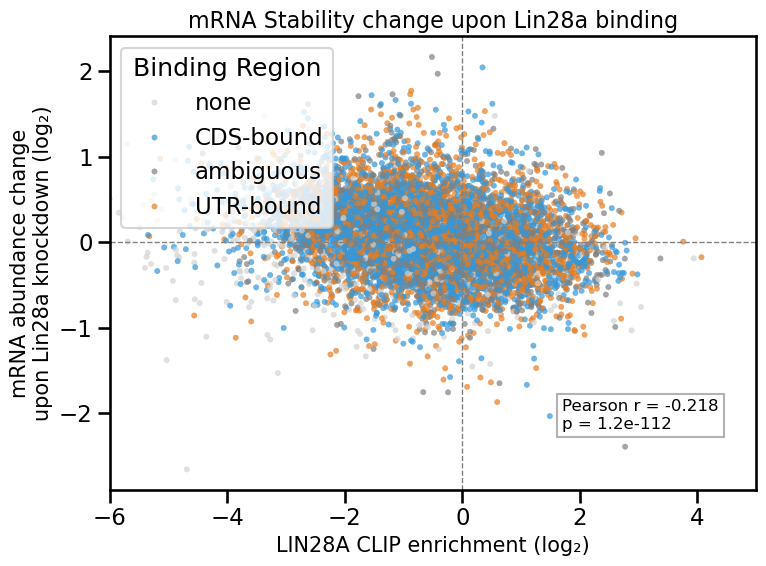

In [207]:
# Lin28a CLIP-enrichment에 따른 mRNA stability 변화 확인

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# 1. CLIP enrichment / RNA change 계산 및 log2 변환

counts_with_binding_rna["clip_enrichment_log2"] = np.log2(counts_with_binding_rna['clip_enrichment'] + 1e-3)


counts_with_binding_rna["rna_change_log2"] = np.log2(counts_with_binding_rna['RNA_change'] + 1e-3)

from scipy.stats import pearsonr
r, p = pearsonr(
    counts_with_binding_rna["clip_enrichment_log2"],
    counts_with_binding_rna["rna_change_log2"]
)
r_text = f"r = {r:.4f}"

# 2. scatter plot (binding_type 기준 색상 구분)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=counts_with_binding_rna,
    x="clip_enrichment_log2",
    y="rna_change_log2",
    hue="binding_type",
    palette={"CDS-bound": "#3498db", "UTR-bound": "#e67e22", "ambiguous": "gray", "none": "lightgray"},
    alpha=0.7,
    edgecolor=None,
    s=15
)

plt.text(
    0.7, 0.2,
    f"Pearson r = {r:.3f}\np = {p:.1e}",
    transform=plt.gca().transAxes,
    ha='left',
    va='top',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
)

# 3. 시각적 마무리
plt.axhline(0, linestyle="--", color="gray", linewidth=1)
plt.axvline(0, linestyle="--", color="gray", linewidth=1)
plt.xlim(-6, 5)
plt.xlabel("LIN28A CLIP enrichment (log₂)", fontsize=15)
plt.ylabel("mRNA abundance change\nupon Lin28a knockdown (log₂)", fontsize=15)
plt.title("mRNA Stability change upon Lin28a binding", fontsize=16)
plt.legend(title="Binding Region", loc="upper left")
plt.tight_layout()
plt.show()

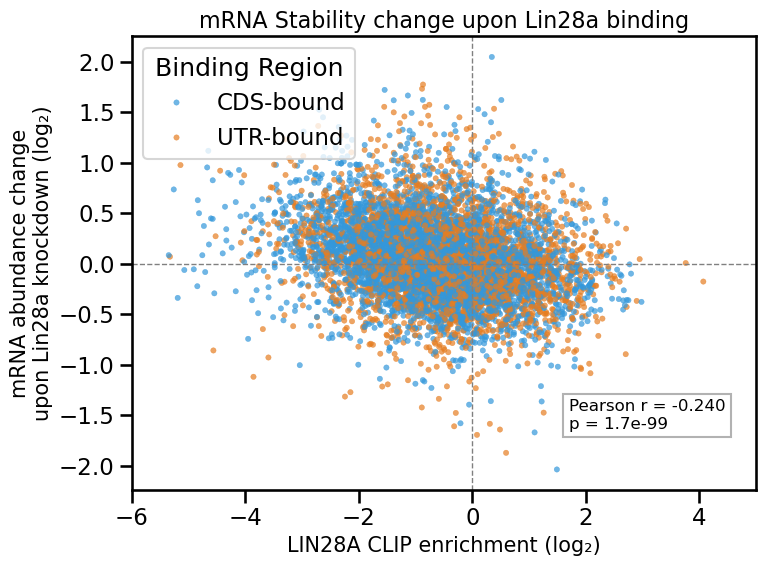

In [203]:
# Lin28a CLIP-enrichment에 따른 mRNA stability 변화 확인

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# 1. CLIP enrichment / RNA change 계산 및 log2 변환

counts_with_binding_rna["clip_enrichment_log2"] = np.log2(counts_with_binding_rna['clip_enrichment'] + 1e-3)


counts_with_binding_rna["rna_change_log2"] = np.log2(counts_with_binding_rna['RNA_change'] + 1e-3)

# 3. binding_type이 CDS-bound 또는 UTR-bound인 경우만
counts_with_binding_filtered_sub = counts_with_binding_rna[counts_with_binding_rna["binding_type"].isin(["CDS-bound", "UTR-bound"])]

# 5. 상관계수 계산
from scipy.stats import pearsonr
r, p = pearsonr(
    counts_with_binding_filtered_sub["clip_enrichment_log2"],
    counts_with_binding_filtered_sub["rna_change_log2"]
)
r_text = f"r = {r:.4f}"


# 4. scatter plot (binding_type 기준 색상 구분)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=counts_with_binding_filtered_sub,
    x="clip_enrichment_log2",
    y="rna_change_log2",
    hue="binding_type",
    palette={"CDS-bound": "#3498db", "UTR-bound": "#e67e22"},
    alpha=0.7,
    edgecolor=None,
    s=15
)

plt.text(
    0.7, 0.2,
    f"Pearson r = {r:.3f}\np = {p:.1e}",
    transform=plt.gca().transAxes,
    ha='left',
    va='top',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
)

# 5. 시각적 마무리
plt.axhline(0, linestyle="--", color="gray", linewidth=1)
plt.axvline(0, linestyle="--", color="gray", linewidth=1)
plt.xlim(-6, 5)
plt.xlabel("LIN28A CLIP enrichment (log₂)", fontsize=15)
plt.ylabel("mRNA abundance change\nupon Lin28a knockdown (log₂)", fontsize=15)
plt.title("mRNA Stability change upon Lin28a binding", fontsize=16)
plt.legend(title="Binding Region", loc="upper left")
plt.tight_layout()
plt.show()

In [83]:
region_peak_counts = counts_with_binding_rna['binding_type'].value_counts()
print(region_peak_counts)

binding_type
CDS-bound    4376
UTR-bound    3195
ambiguous    2336
none          574
Name: count, dtype: int64


CDS-bound gene만을 모아서 visualization

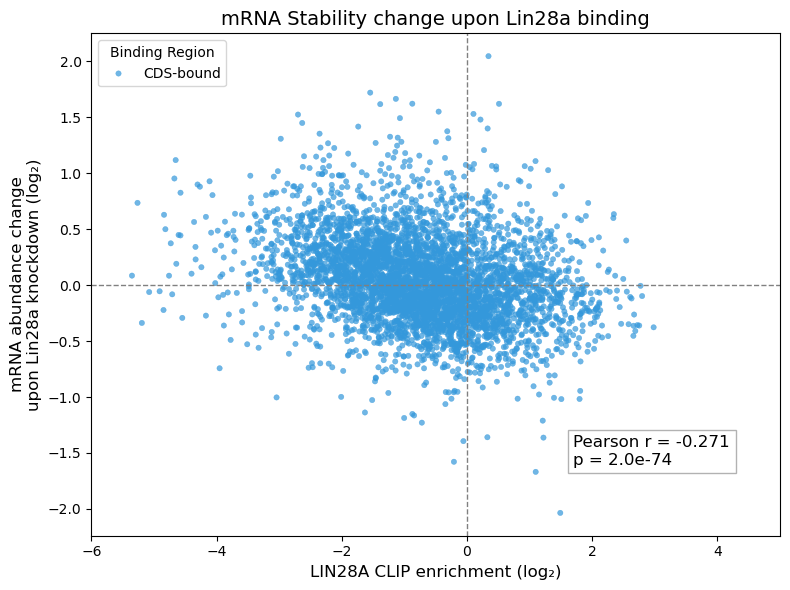

In [87]:
# Lin28a CLIP-enrichment에 따른 mRNA stability 변화 확인

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 2. CLIP enrichment / RNA change 계산 및 log2 변환
counts_with_binding_rna["clip_enrichment_log2"] = np.log2(counts_with_binding_rna['clip_enrichment'] + 1e-3)


counts_with_binding_rna["rna_change_log2"] = np.log2(counts_with_binding_rna['RNA_change'] + 1e-3)

# 3. binding_type이 CDS-bound 또는 UTR-bound인 경우만
counts_with_binding_rna_sub1 = counts_with_binding_rna[counts_with_binding_rna["binding_type"].isin(["CDS-bound"])]

# 5. 상관계수 계산
from scipy.stats import pearsonr
r, p = pearsonr(
    counts_with_binding_rna_sub1["clip_enrichment_log2"],
    counts_with_binding_rna_sub1["rna_change_log2"]
)
r_text = f"r = {r:.4f}"


# 4. scatter plot (binding_type 기준 색상 구분)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=counts_with_binding_rna_sub1,
    x="clip_enrichment_log2",
    y="rna_change_log2",
    hue="binding_type",
    palette={"CDS-bound": "#3498db"},
    alpha=0.7,
    edgecolor=None,
    s=15
)

plt.text(
    0.7, 0.2,
    f"Pearson r = {r:.3f}\np = {p:.1e}",
    transform=plt.gca().transAxes,
    ha='left',
    va='top',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
)

# 5. 시각적 마무리
plt.axhline(0, linestyle="--", color="gray", linewidth=1)
plt.axvline(0, linestyle="--", color="gray", linewidth=1)
plt.xlim(-6, 5)
plt.xlabel("LIN28A CLIP enrichment (log₂)", fontsize=12)
plt.ylabel("mRNA abundance change\nupon Lin28a knockdown (log₂)", fontsize=12)
plt.title("mRNA Stability change upon Lin28a binding", fontsize=14)
plt.legend(title="Binding Region", loc="upper left")
plt.tight_layout()
plt.show()

2. UTR-bound 만을 모아서 visualization

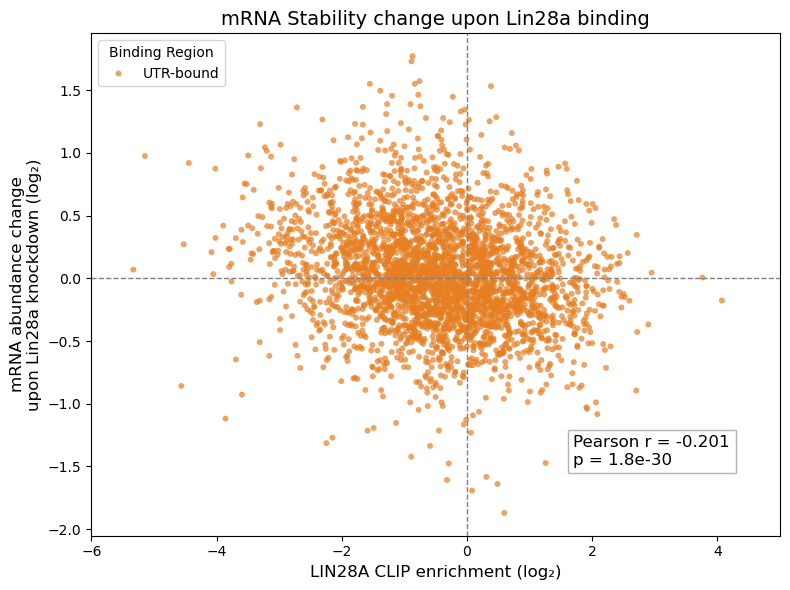

In [86]:
# Lin28a CLIP-enrichment에 따른 mRNA stability 변화 확인

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 2. CLIP enrichment / RNA change 계산 및 log2 변환
counts_with_binding_rna["clip_enrichment_log2"] = np.log2(counts_with_binding_rna['clip_enrichment'] + 1e-3)


counts_with_binding_rna["rna_change_log2"] = np.log2(counts_with_binding_rna['RNA_change'] + 1e-3)

# 3. binding_type이 CDS-bound 또는 UTR-bound인 경우만
counts_with_binding_rna_sub2 = counts_with_binding_rna[counts_with_binding_rna["binding_type"].isin(["UTR-bound"])]

# 5. 상관계수 계산
from scipy.stats import pearsonr
r, p = pearsonr(
    counts_with_binding_rna_sub2["clip_enrichment_log2"],
    counts_with_binding_rna_sub2["rna_change_log2"]
)
r_text = f"r = {r:.4f}"


# 4. scatter plot (binding_type 기준 색상 구분)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=counts_with_binding_rna_sub2,
    x="clip_enrichment_log2",
    y="rna_change_log2",
    hue="binding_type",
    palette={"UTR-bound": "#e67e22"},
    alpha=0.7,
    edgecolor=None,
    s=15
)

plt.text(
    0.7, 0.2,
    f"Pearson r = {r:.3f}\np = {p:.1e}",
    transform=plt.gca().transAxes,
    ha='left',
    va='top',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
)

# 5. 시각적 마무리
plt.axhline(0, linestyle="--", color="gray", linewidth=1)
plt.axvline(0, linestyle="--", color="gray", linewidth=1)
plt.xlim(-6, 5)
plt.xlabel("LIN28A CLIP enrichment (log₂)", fontsize=12)
plt.ylabel("mRNA abundance change\nupon Lin28a knockdown (log₂)", fontsize=12)
plt.title("mRNA Stability change upon Lin28a binding", fontsize=14)
plt.legend(title="Binding Region", loc="upper left")
plt.tight_layout()
plt.show()

##### 2. Translation change visualization

Ribosome density change 

In [4]:
## binding region 열 추가된 count data 확인
import pandas as pd

counts_with_binding_ribo = pd.read_csv("read_counts_for_ribo_change_with_binding_type.txt", sep="\t", comment="#", index_col=0)
counts_with_binding_ribo.head()

,CLIP-35L33G.bam,RNA-control.bam,RNA-siLin28a.bam,RNA-siLuc.bam,RPF-siLin28a.bam,RPF-siLuc.bam,binding_type
Geneid,,,,,,,
ENSMUSG00000033845.14,34.697421,30.698131,28.859290,30.977319,20.482286,29.073501,CDS-bound
ENSMUSG00000033813.16,40.316540,48.563111,57.220240,75.649162,10.166039,15.608699,ambiguous
ENSMUSG00000033793.13,8.362992,9.351446,10.478268,10.851298,5.785543,8.949678,CDS-bound
ENSMUSG00000025907.15,7.590945,3.664908,3.828980,6.305440,0.840244,1.321225,CDS-bound
ENSMUSG00000051285.18,38.676826,15.286206,28.745812,27.363080,2.923033,1.603692,UTR-bound


In [7]:
# read count data에 CLIP-enrichment, rden_change, RNA_change 열 추가

counts_with_binding_ribo['clip_enrichment'] = (counts_with_binding_ribo['CLIP-35L33G.bam']) / (counts_with_binding_ribo['RNA-control.bam'])
counts_with_binding_ribo['rden_change'] = (counts_with_binding_ribo['RPF-siLin28a.bam']/counts_with_binding_ribo['RNA-siLin28a.bam']) / (counts_with_binding_ribo['RPF-siLuc.bam']/counts_with_binding_ribo['RNA-siLuc.bam'])
counts_with_binding_ribo['RNA_change'] = (counts_with_binding_ribo['RNA-siLin28a.bam']) / (counts_with_binding_ribo['RNA-siLuc.bam'])
counts_with_binding_ribo.head()

,CLIP-35L33G.bam,RNA-control.bam,RNA-siLin28a.bam,RNA-siLuc.bam,RPF-siLin28a.bam,RPF-siLuc.bam,binding_type,clip_enrichment,rden_change,RNA_change,clip_enrichment_log2,rden_change_log2
Geneid,,,,,,,,,,,,
ENSMUSG00000033845.14,34.697421,30.698131,28.859290,30.977319,20.482286,29.073501,CDS-bound,1.130278,0.756205,0.931626,0.177953,-0.401245
ENSMUSG00000033813.16,40.316540,48.563111,57.220240,75.649162,10.166039,15.608699,ambiguous,0.830189,0.861072,0.756390,-0.266752,-0.214120
ENSMUSG00000033793.13,8.362992,9.351446,10.478268,10.851298,5.785543,8.949678,CDS-bound,0.894299,0.669467,0.965624,-0.159558,-0.576763
ENSMUSG00000025907.15,7.590945,3.664908,3.828980,6.305440,0.840244,1.321225,CDS-bound,2.071251,1.047276,0.607250,1.051199,0.068018
ENSMUSG00000051285.18,38.676826,15.286206,28.745812,27.363080,2.923033,1.603692,UTR-bound,2.530178,1.735015,1.050533,1.339809,0.795779


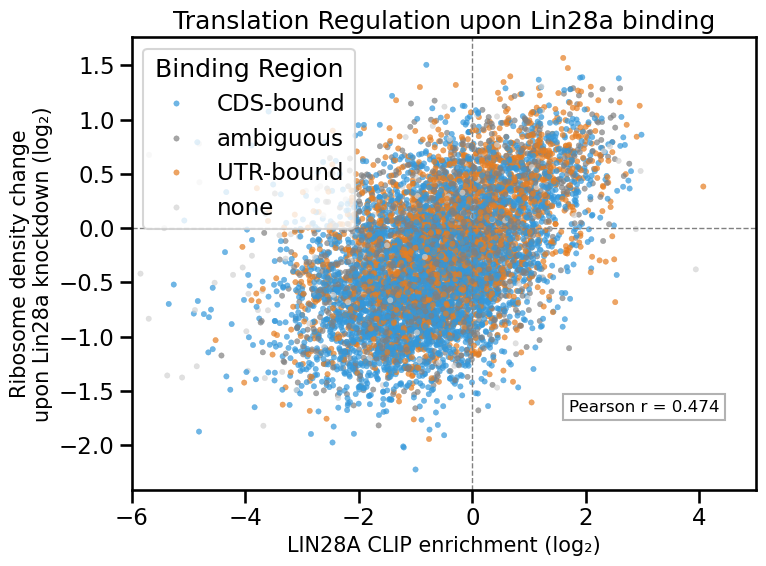

In [206]:
# Lin28a CLIP-enrichment에 따른 mRNA stability 변화 확인

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# 1. CLIP enrichment / RNA change 계산 및 log2 변환

counts_with_binding_ribo["clip_enrichment_log2"] = np.log2(counts_with_binding_ribo['clip_enrichment'] + 1e-3)
counts_with_binding_ribo["rden_change_log2"] = np.log2(counts_with_binding_ribo['rden_change'] + 1e-3)

# x, y 데이터 준비
x = counts_with_binding_ribo["clip_enrichment_log2"]
y = counts_with_binding_ribo["rden_change_log2"]

# 상관계수 계산
from scipy.stats import pearsonr
r, _ = pearsonr(x, y) 


# 2. scatter plot (binding_type 기준 색상 구분)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=counts_with_binding_ribo,
    x="clip_enrichment_log2",
    y="rden_change_log2",
    hue="binding_type",
    palette={"CDS-bound": "#3498db", "UTR-bound": "#e67e22", "ambiguous": "gray", "none": "lightgray"},
    alpha=0.7,
    edgecolor=None,
    s=15
)

# r 값만 표시
plt.text(
    0.7, 0.2,
    f"Pearson r = {r:.3f}",
    transform=plt.gca().transAxes,
    ha='left', va='top',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
)

# 3. 시각적 마무리
plt.axhline(0, linestyle="--", color="gray", linewidth=1)
plt.axvline(0, linestyle="--", color="gray", linewidth=1)
plt.title("Translation Regulation upon Lin28a binding")
plt.xlim(-6, 5)
plt.xlabel("LIN28A CLIP enrichment (log₂)", fontsize=15)
plt.ylabel("Ribosome density change\nupon Lin28a knockdown (log₂)", fontsize=15)
plt.legend(title="Binding Region", loc="upper left")
plt.tight_layout()
plt.show()

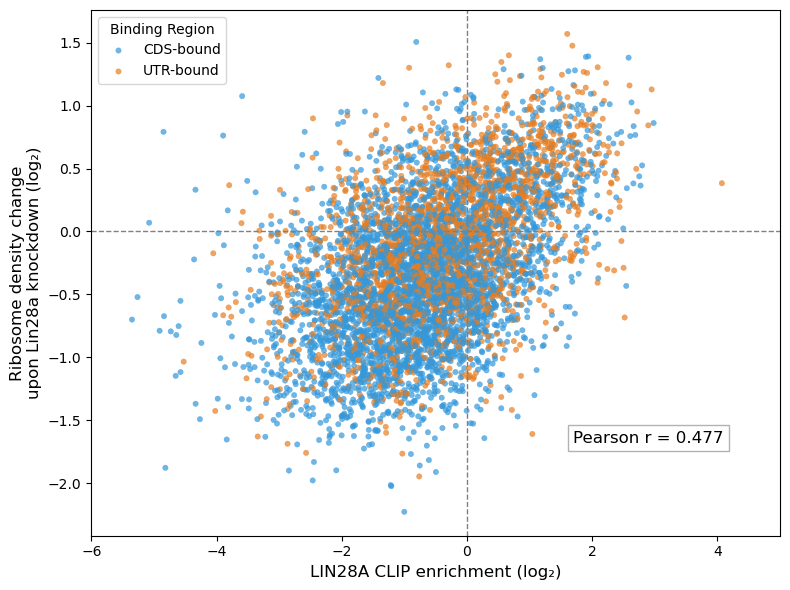

In [21]:
# Lin28a CLIP-enrichment에 따른 mRNA stability 변화 확인

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# 1. CLIP enrichment / RNA change 계산 및 log2 변환

counts_with_binding_ribo["clip_enrichment_log2"] = np.log2(counts_with_binding_ribo['clip_enrichment'] + 1e-3)
counts_with_binding_ribo["rden_change_log2"] = np.log2(counts_with_binding_ribo['rden_change'] + 1e-3)

counts_with_binding_ribo_sub = counts_with_binding_ribo[counts_with_binding_ribo["binding_type"].isin(["CDS-bound", "UTR-bound"])]

# x, y 데이터 준비
x = counts_with_binding_ribo_sub["clip_enrichment_log2"]
y = counts_with_binding_ribo_sub["rden_change_log2"]

# 상관계수 계산
r, _ = pearsonr(x, y) 


# 2. scatter plot (binding_type 기준 색상 구분)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=counts_with_binding_ribo_sub,
    x="clip_enrichment_log2",
    y="rden_change_log2",
    hue="binding_type",
    palette={"CDS-bound": "#3498db", "UTR-bound": "#e67e22"},
    alpha=0.7,
    edgecolor=None,
    s=15
)

# r 값만 표시
plt.text(
    0.7, 0.2,
    f"Pearson r = {r:.3f}",
    transform=plt.gca().transAxes,
    ha='left', va='top',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
)

# 3. 시각적 마무리
plt.axhline(0, linestyle="--", color="gray", linewidth=1)
plt.axvline(0, linestyle="--", color="gray", linewidth=1)
plt.xlim(-6, 5)
plt.xlabel("LIN28A CLIP enrichment (log₂)", fontsize=12)
plt.ylabel("Ribosome density change\nupon Lin28a knockdown (log₂)", fontsize=12)
plt.legend(title="Binding Region", loc="upper left")
plt.tight_layout()
plt.show()

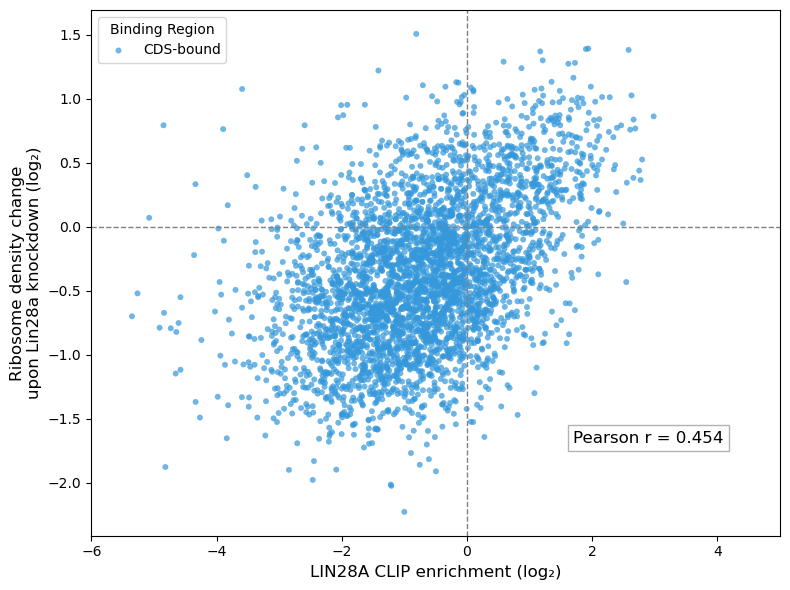

In [22]:
# Lin28a CLIP-enrichment에 따른 mRNA stability 변화 확인

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# 1. CLIP enrichment / RNA change 계산 및 log2 변환

counts_with_binding_ribo["clip_enrichment_log2"] = np.log2(counts_with_binding_ribo['clip_enrichment'] + 1e-3)
counts_with_binding_ribo["rden_change_log2"] = np.log2(counts_with_binding_ribo['rden_change'] + 1e-3)

counts_with_binding_ribo_sub1 = counts_with_binding_ribo[counts_with_binding_ribo["binding_type"].isin(["CDS-bound"])]

# x, y 데이터 준비
x = counts_with_binding_ribo_sub1["clip_enrichment_log2"]
y = counts_with_binding_ribo_sub1["rden_change_log2"]

# 상관계수 계산
r, _ = pearsonr(x, y) 


# 2. scatter plot (binding_type 기준 색상 구분)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=counts_with_binding_ribo_sub1,
    x="clip_enrichment_log2",
    y="rden_change_log2",
    hue="binding_type",
    palette={"CDS-bound": "#3498db"},
    alpha=0.7,
    edgecolor=None,
    s=15
)

# r 값만 표시
plt.text(
    0.7, 0.2,
    f"Pearson r = {r:.3f}",
    transform=plt.gca().transAxes,
    ha='left', va='top',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
)

# 3. 시각적 마무리
plt.axhline(0, linestyle="--", color="gray", linewidth=1)
plt.axvline(0, linestyle="--", color="gray", linewidth=1)
plt.xlim(-6, 5)
plt.xlabel("LIN28A CLIP enrichment (log₂)", fontsize=12)
plt.ylabel("Ribosome density change\nupon Lin28a knockdown (log₂)", fontsize=12)
plt.legend(title="Binding Region", loc="upper left")
plt.tight_layout()
plt.show()

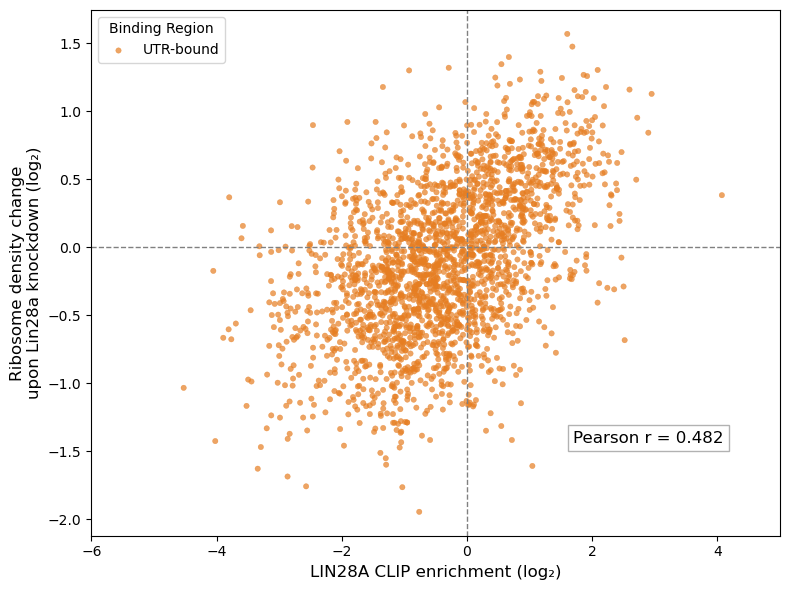

In [23]:
# Lin28a CLIP-enrichment에 따른 mRNA stability 변화 확인

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# 1. CLIP enrichment / RNA change 계산 및 log2 변환

counts_with_binding_ribo["clip_enrichment_log2"] = np.log2(counts_with_binding_ribo['clip_enrichment'] + 1e-3)
counts_with_binding_ribo["rden_change_log2"] = np.log2(counts_with_binding_ribo['rden_change'] + 1e-3)

counts_with_binding_ribo_sub2 = counts_with_binding_ribo[counts_with_binding_ribo["binding_type"].isin(["UTR-bound"])]

# x, y 데이터 준비
x = counts_with_binding_ribo_sub2["clip_enrichment_log2"]
y = counts_with_binding_ribo_sub2["rden_change_log2"]

# 상관계수 계산
r, _ = pearsonr(x, y) 


# 2. scatter plot (binding_type 기준 색상 구분)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=counts_with_binding_ribo_sub2,
    x="clip_enrichment_log2",
    y="rden_change_log2",
    hue="binding_type",
    palette={"UTR-bound": "#e67e22"},
    alpha=0.7,
    edgecolor=None,
    s=15
)

# r 값만 표시
plt.text(
    0.7, 0.2,
    f"Pearson r = {r:.3f}",
    transform=plt.gca().transAxes,
    ha='left', va='top',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
)

# 3. 시각적 마무리
plt.axhline(0, linestyle="--", color="gray", linewidth=1)
plt.axvline(0, linestyle="--", color="gray", linewidth=1)
plt.xlim(-6, 5)
plt.xlabel("LIN28A CLIP enrichment (log₂)", fontsize=12)
plt.ylabel("Ribosome density change\nupon Lin28a knockdown (log₂)", fontsize=12)
plt.legend(title="Binding Region", loc="upper left")
plt.tight_layout()
plt.show()

In [35]:
import numpy as np
import pandas as pd

# 가정: counts_with_binding_ribo 에
#   'binding_type', 'clip_enrichment_log2', 'rden_change_log2' 컬럼이 이미 있음

df = counts_with_binding_ribo.copy()

# 1) 특정 cutoff 정의
en_cut = 0.5    # log2 enrichment ≥ 1  → CLIP 2배 이상
rdn_pos =  0.5  # log2 density change ≥ +0.5 → Lin28a KD 시 번역 증가가

# 2) CDS-bound 중 강하게 억제된 유전자
cds_sel = df[
    (df['binding_type']=="CDS-bound") &
    (df['clip_enrichment_log2'] >= en_cut) &
    (df['rden_change_log2'] >= rdn_pos)
].index.tolist()

# 3) UTR-bound 중 강하게 억제된 유전자
utr_sel = df[
    (df['binding_type']=="UTR-bound") &
    (df['clip_enrichment_log2'] >= en_cut) &
    (df['rden_change_log2'] >= rdn_pos)
].index.tolist()

print("CDS-bound & translation ↓ gene count:", len(cds_sel))
print("UTR-bound & translation ↓ gene count:", len(utr_sel))

print(cds_sel)
print(utr_sel)

CDS-bound & translation ↓ gene count: 158
UTR-bound & translation ↓ gene count: 194
['ENSMUSG00000026111.16', 'ENSMUSG00000025986.7', 'ENSMUSG00000038079.15', 'ENSMUSG00000025964.16', 'ENSMUSG00000026342.11', 'ENSMUSG00000026469.15', 'ENSMUSG00000040297.13', 'ENSMUSG00000056050.16', 'ENSMUSG00000016481.16', 'ENSMUSG00000036327.19', 'ENSMUSG00000026837.17', 'ENSMUSG00000026836.16', 'ENSMUSG00000026980.16', 'ENSMUSG00000035000.9', 'ENSMUSG00000027111.17', 'ENSMUSG00000025314.17', 'ENSMUSG00000027198.17', 'ENSMUSG00000070730.12', 'ENSMUSG00000027204.14', 'ENSMUSG00000027365.15', 'ENSMUSG00000014353.16', 'ENSMUSG00000027276.8', 'ENSMUSG00000017707.10', 'ENSMUSG00000006800.15', 'ENSMUSG00000027706.9', 'ENSMUSG00000037400.18', 'ENSMUSG00000037270.19', 'ENSMUSG00000037016.12', 'ENSMUSG00000036334.13', 'ENSMUSG00000027820.13', 'ENSMUSG00000027822.17', 'ENSMUSG00000027966.21', 'ENSMUSG00000027999.16', 'ENSMUSG00000028232.14', 'ENSMUSG00000028207.19', 'ENSMUSG00000073987.5', 'ENSMUSG00000028293.

                       clip_enrichment_log2
Geneid                                     
ENSMUSG00000026111.16              0.688656
ENSMUSG00000025986.7               2.042376
ENSMUSG00000038079.15              1.833538
ENSMUSG00000025964.16              1.024780
ENSMUSG00000026342.11              2.079115
...                                     ...
ENSMUSG00000095180.11              0.763909
ENSMUSG00000031119.5               1.756596
ENSMUSG00000055653.14              0.615185
ENSMUSG00000062949.14              1.479744
ENSMUSG00000047757.18              1.012743

[158 rows x 1 columns]
                       rden_change_log2
Geneid                                 
ENSMUSG00000026111.16          0.559739
ENSMUSG00000025986.7           0.619205
ENSMUSG00000038079.15          0.570284
ENSMUSG00000025964.16          0.679678
ENSMUSG00000026342.11          0.670284
...                                 ...
ENSMUSG00000095180.11          0.555845
ENSMUSG00000031119.5           0.622645
ENSM

In [36]:
import pandas as pd

# cds_sel, utr_sel 은 이미 리스트 형태로 준비되어 있다고 가정합니다.

# 1) CDS-bound 리스트 저장
pd.Series(cds_sel, name='Geneid') \
  .to_csv("CDS_rden_change_sig_genes_enrich_1.txt",
          sep="\t",
          index=False,
          header=True)

print(cds_sel)

# 2) UTR-bound 리스트 저장
pd.Series(utr_sel, name='Geneid') \
  .to_csv("UTR_rden_change_sig_genes_enrich_1.txt",
          sep="\t",
          index=False,
          header=True)

print(utr_sel)


['ENSMUSG00000026111.16', 'ENSMUSG00000025986.7', 'ENSMUSG00000038079.15', 'ENSMUSG00000025964.16', 'ENSMUSG00000026342.11', 'ENSMUSG00000026469.15', 'ENSMUSG00000040297.13', 'ENSMUSG00000056050.16', 'ENSMUSG00000016481.16', 'ENSMUSG00000036327.19', 'ENSMUSG00000026837.17', 'ENSMUSG00000026836.16', 'ENSMUSG00000026980.16', 'ENSMUSG00000035000.9', 'ENSMUSG00000027111.17', 'ENSMUSG00000025314.17', 'ENSMUSG00000027198.17', 'ENSMUSG00000070730.12', 'ENSMUSG00000027204.14', 'ENSMUSG00000027365.15', 'ENSMUSG00000014353.16', 'ENSMUSG00000027276.8', 'ENSMUSG00000017707.10', 'ENSMUSG00000006800.15', 'ENSMUSG00000027706.9', 'ENSMUSG00000037400.18', 'ENSMUSG00000037270.19', 'ENSMUSG00000037016.12', 'ENSMUSG00000036334.13', 'ENSMUSG00000027820.13', 'ENSMUSG00000027822.17', 'ENSMUSG00000027966.21', 'ENSMUSG00000027999.16', 'ENSMUSG00000028232.14', 'ENSMUSG00000028207.19', 'ENSMUSG00000073987.5', 'ENSMUSG00000028293.15', 'ENSMUSG00000028476.14', 'ENSMUSG00000028343.11', 'ENSMUSG00000028412.18', 'ENS

In [37]:
# ESC에서 발현하는 RNA를 Gene Ontology의 background gene list로 설정정
import pandas as pd
cnts = pd.read_csv('read-counts_bg.txt', sep='\t', comment='#', index_col=0)
cnts.head()



,Chr,Start,End,Strand,Length,RNA-control.bam
Geneid,,,,,,
ENSMUSG00000102693.2,chr1,3143476,3144545,+,1070,0
ENSMUSG00000064842.3,chr1,3172239,3172348,+,110,0
ENSMUSG00000051951.6,chr1;chr1;chr1;chr1;chr1;chr1;chr1,3276124;3276746;3283662;3283832;3284705;349192...,3277540;3277540;3285855;3286567;3287191;349212...,-;-;-;-;-;-;-,6094,1
ENSMUSG00000102851.2,chr1,3322980,3323459,+,480,0
ENSMUSG00000103377.2,chr1,3435954,3438772,-,2819,0


In [38]:
import pandas as pd
from gprofiler import GProfiler

# 버전 접미사 제거
## 진짜 중요!! 버전 제거하지 않으면 g:profiler가 제대로 ID를 인식하지 못함 
def strip_version(ids):
    return [g.split('.')[0] for g in ids]


# 1) background: CLIP-seq을 진행한 마우스 ESC에서의 전사체
bg_df = pd.read_csv('read-counts_bg.txt', sep='\t', comment='#', index_col=0)
background = bg_df[bg_df['RNA-control.bam'] > 10].index.tolist()
background_clean = strip_version(background)

# 2) query: CDS-translation-↓ 혹은 UTR-translation-↓ 리스트
cds_down = pd.read_csv("CDS_rden_change_sig_genes_enrich_1.txt", sep="\t", header=0)['Geneid'].tolist()
utr_down = pd.read_csv("UTR_rden_change_sig_genes_enrich_1.txt", sep="\t", header=0)['Geneid'].tolist()

cds_down_clean = strip_version(cds_down)
utr_down_clean = strip_version(utr_down)

#print(cds_down.len)
#print(utr_down)
# 3) g:Profiler 초기화 (마우스 유전자 설정)
gp = GProfiler(return_dataframe=True)

# 4) CDS-bound downregulated 유전자 GO/KEGG 분석
res_cds = gp.profile(
    query= cds_down_clean,
    background=background_clean,
    domain_scope='custom',
    organism='mmusculus',
    sources=['GO:BP', 'GO:MF', 'GO:CC'],
)

# 5) UTR-bound downregulated 유전자 GO/KEGG 분석
res_utr = gp.profile(
    query= utr_down_clean,
    background=background_clean,
    domain_scope='custom',
    organism='mmusculus',
    sources=['GO:BP', 'GO:MF', 'GO:CC'],
)

# 결과 확인 (기본 보정·컷오프 적용)
print("=== CDS-bound enrichment ===")
print(res_cds)

print("=== UTR-bound enrichment ===")
print(res_utr)

=== CDS-bound enrichment ===
   source      native                           name       p_value  \
0   GO:CC  GO:0016020                       membrane  1.207040e-30   
1   GO:CC  GO:0071944                 cell periphery  8.139925e-20   
2   GO:CC  GO:0012505            endomembrane system  6.885824e-19   
3   GO:CC  GO:0110165  cellular anatomical structure  8.115198e-17   
4   GO:CC  GO:0009986                   cell surface  1.316439e-16   
..    ...         ...                            ...           ...   
65  GO:BP  GO:0040011                     locomotion  3.199396e-02   
66  GO:BP  GO:0055080  monoatomic cation homeostasis  3.275409e-02   
67  GO:MF  GO:0030246           carbohydrate binding  3.450490e-02   
68  GO:BP  GO:0044409       symbiont entry into host  3.591541e-02   
69  GO:BP  GO:0050801     monoatomic ion homeostasis  4.101826e-02   

    significant                                        description  term_size  \
0          True  "A lipid bilayer along with all 

In [39]:
print(res_cds.columns)

Index(['source', 'native', 'name', 'p_value', 'significant', 'description',
       'term_size', 'query_size', 'intersection_size', 'effective_domain_size',
       'precision', 'recall', 'query', 'parents'],
      dtype='object')


In [188]:
import pandas as pd
import numpy as np

# 가정: go_result 는 이미 g:Profiler로 얻은 결과 DataFrame
# go_result.columns 예시: ['source','native','name','p_value','significant','description',
#                            'term_size','query_size','intersection_size','precision','recall','query','parents', ...]

# 1) GO:BP 항만 필터
bp_df_cds = res_cds[res_cds['source'] == 'GO:BP'].copy()

# 2) GO:MF 항만 필터
mf_df_cds = res_cds[res_cds['source'] == 'GO:MF'].copy()

# 3) GO:CC 항만 필터
cc_df_cds = res_cds[res_cds['source'] == 'GO:CC'].copy()

# 각 카테고리별로 유의미한 항만 추리기
bp_sig_cds   = bp_df_cds[bp_df_cds['significant'] == True].copy()
mf_sig_cds   = mf_df_cds[mf_df_cds['significant'] == True].copy()
cc_sig_cds   = cc_df_cds[cc_df_cds['significant'] == True].copy()

# term size 조정
# p-value 기준으로 정렬해서 상위 10개씩 뽑기
bp_sig_cds_specific = bp_sig_cds[bp_sig_cds['term_size'] < 1000].copy()
bp_top10 = bp_sig_cds_specific.sort_values('p_value').head(10).reset_index(drop=True)

mf_sig_cds_specific = mf_sig_cds[mf_sig_cds['term_size'] < 1000].copy()
mf_top10 = mf_sig_cds_specific.sort_values('p_value').head(10).reset_index(drop=True)

cc_sig_cds_specific = cc_sig_cds[cc_sig_cds['term_size'] < 1000].copy()
cc_top10 = cc_sig_cds_specific.sort_values('p_value').head(10).reset_index(drop=True)

/tmp/ipykernel_3922074/715676803.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_3922074/715676803.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=13)  # 💡 y축 font 크기 조절


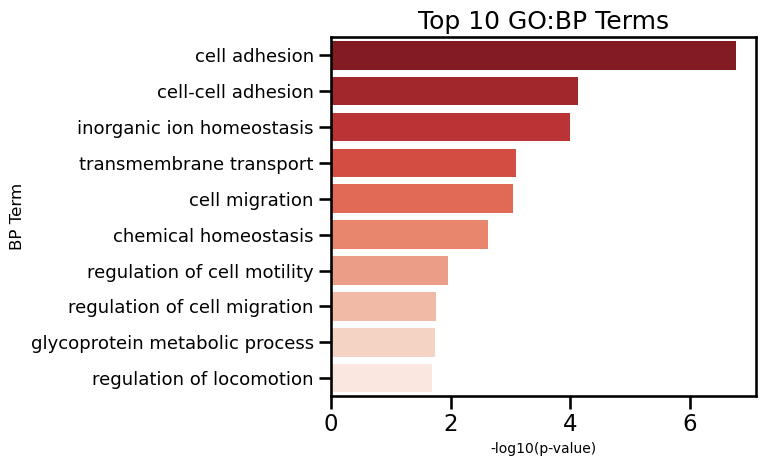

/tmp/ipykernel_3922074/715676803.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


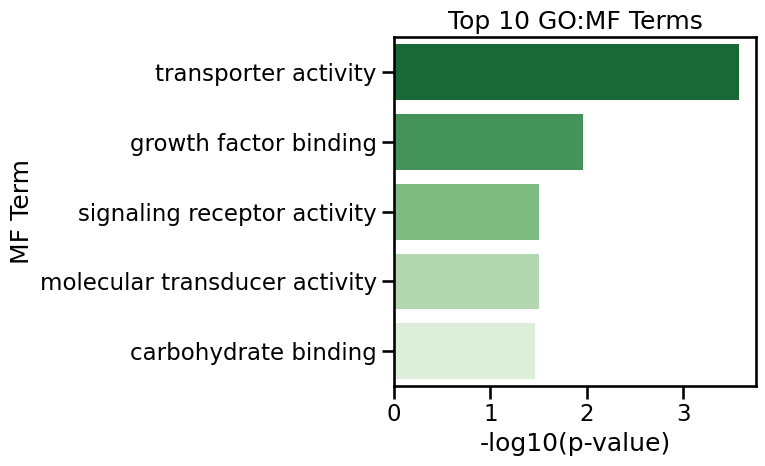

/tmp/ipykernel_3922074/715676803.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_3922074/715676803.py:50: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


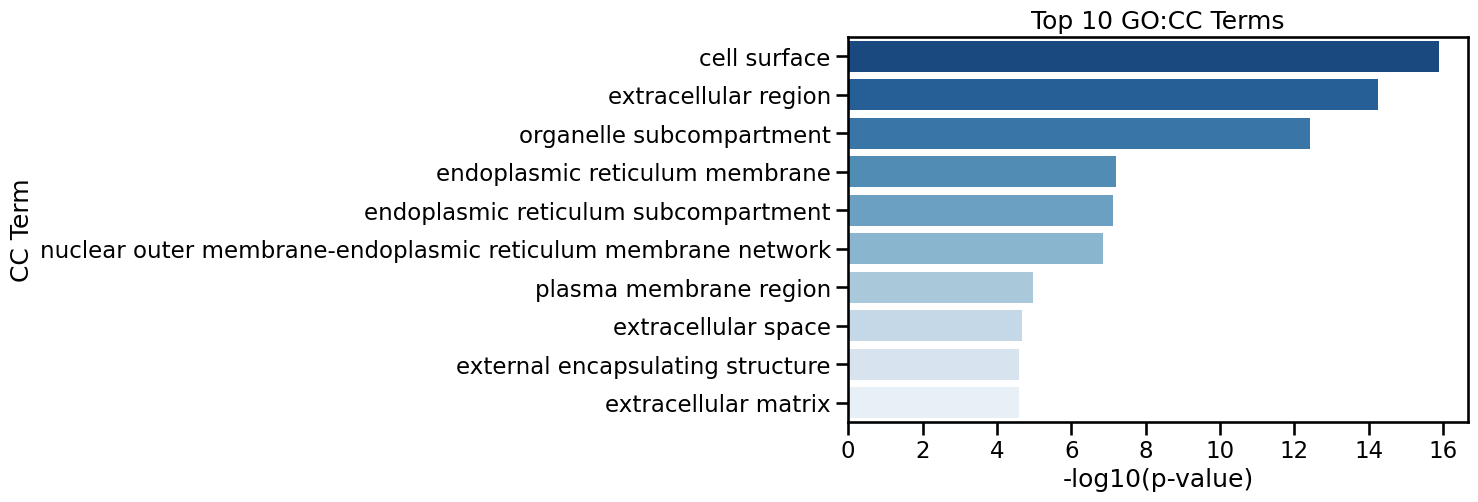

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns

# 공통 설정: −log10(p-value) 계산
for df in [bp_top10, mf_top10, cc_top10]:
    df['minus_log10_p'] = -np.log10(df['p_value'])

# 2-1) GO:BP 상위 10개 Bar Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=bp_top10,
    y='name',
    x='minus_log10_p',
    palette='Reds_r'
)
plt.title('Top 10 GO:BP Terms')
plt.xlabel('-log10(p-value)', fontsize=10)
plt.ylabel('BP Term', fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=13)  # 💡 y축 font 크기 조절
plt.tight_layout()
plt.show()


# 2-2) GO:MF 상위 10개 Bar Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=mf_top10,
    y='name',
    x='minus_log10_p',
    palette='Greens_r'  # MF는 초록 계열
)
plt.title('Top 10 GO:MF Terms')
plt.xlabel('-log10(p-value)')
plt.ylabel('MF Term')
plt.tight_layout()
plt.show()


# 2-3) GO:CC 상위 10개 Bar Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=cc_top10,
    y='name',
    x='minus_log10_p',
    palette='Blues_r'  # CC는 파랑 계열
)
plt.title('Top 10 GO:CC Terms')
plt.xlabel('-log10(p-value)')
plt.ylabel('CC Term')
plt.tight_layout()
plt.show()

In [57]:
# UTR-bound Gene ontology
import pandas as pd
import numpy as np

# 가정: go_result 는 이미 g:Profiler로 얻은 결과 DataFrame
# go_result.columns 예시: ['source','native','name','p_value','significant','description',
#                            'term_size','query_size','intersection_size','precision','recall','query','parents', ...]

# 1) GO:BP 항만 필터
bp_df_utr = res_utr[res_utr['source'] == 'GO:BP'].copy()

# 2) GO:MF 항만 필터
mf_df_utr = res_utr[res_utr['source'] == 'GO:MF'].copy()

# 3) GO:CC 항만 필터
cc_df_utr = res_utr[res_utr['source'] == 'GO:CC'].copy()

# 각 카테고리별로 유의미한 항만 추리기
bp_sig_utr   = bp_df_utr[bp_df_utr['significant'] == True].copy()
mf_sig_utr   = mf_df_utr[mf_df_utr['significant'] == True].copy()
cc_sig_utr   = cc_df_utr[cc_df_utr['significant'] == True].copy()

# term size 조정
# p-value 기준으로 정렬해서 상위 10개씩 뽑기
bp_sig_utr_specific = bp_sig_utr[bp_sig_utr['term_size'] < 1000].copy()
bp_top10 = bp_sig_utr_specific.sort_values('p_value').head(10).reset_index(drop=True)

mf_sig_utr_specific = mf_sig_utr[mf_sig_utr['term_size'] < 1000].copy()
mf_top10 = mf_sig_utr_specific.sort_values('p_value').head(10).reset_index(drop=True)

cc_sig_utr_specific = cc_sig_utr[cc_sig_utr['term_size'] < 1000].copy()
cc_top10 = cc_sig_utr_specific.sort_values('p_value').head(10).reset_index(drop=True)

/tmp/ipykernel_3922074/2872475012.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


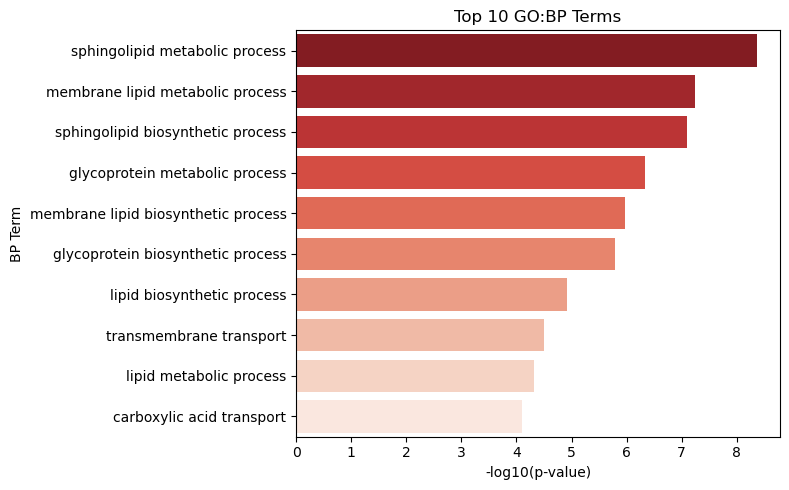

/tmp/ipykernel_3922074/2872475012.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


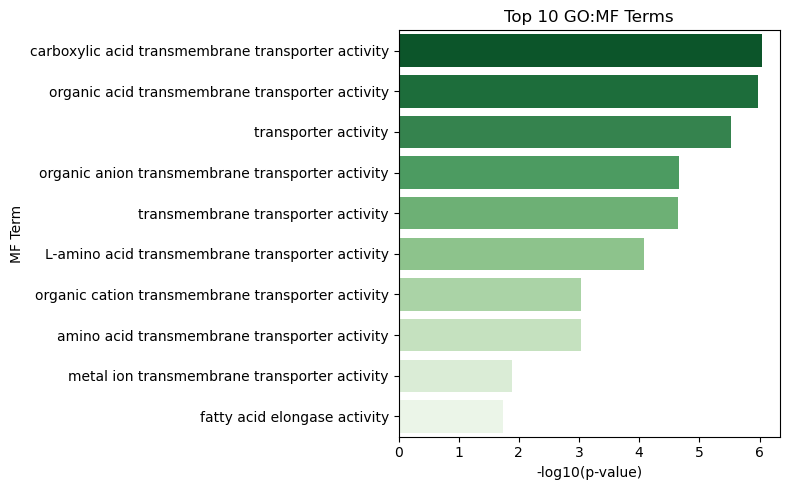

/tmp/ipykernel_3922074/2872475012.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


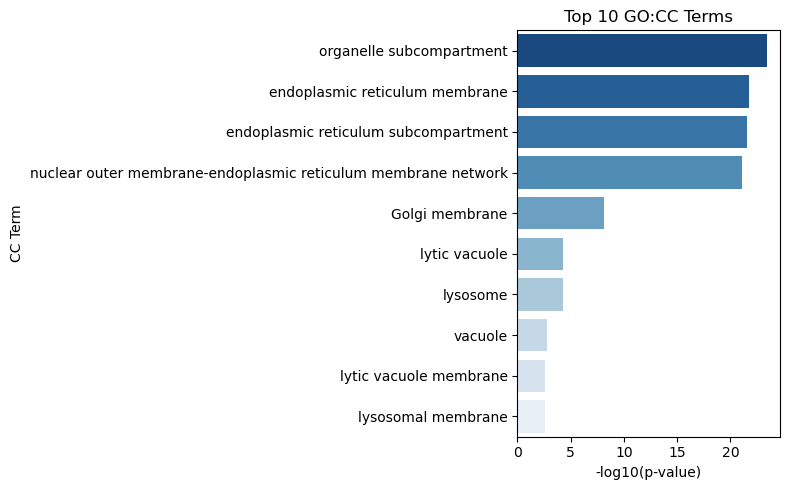

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# 공통 설정: −log10(p-value) 계산
for df in [bp_top10, mf_top10, cc_top10]:
    df['minus_log10_p'] = -np.log10(df['p_value'])

# 2-1) GO:BP 상위 10개 Bar Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=bp_top10,
    y='name',
    x='minus_log10_p',
    palette='Reds_r'   # BP는 빨간 계열
)
plt.title('Top 10 GO:BP Terms')
plt.xlabel('-log10(p-value)')
plt.ylabel('BP Term')
plt.tight_layout()
plt.show()


# 2-2) GO:MF 상위 10개 Bar Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=mf_top10,
    y='name',
    x='minus_log10_p',
    palette='Greens_r'  # MF는 초록 계열
)
plt.title('Top 10 GO:MF Terms')
plt.xlabel('-log10(p-value)')
plt.ylabel('MF Term')
plt.tight_layout()
plt.show()


# 2-3) GO:CC 상위 10개 Bar Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=cc_top10,
    y='name',
    x='minus_log10_p',
    palette='Blues_r'  # CC는 파랑 계열
)
plt.title('Top 10 GO:CC Terms')
plt.xlabel('-log10(p-value)')
plt.ylabel('CC Term')
plt.tight_layout()
plt.show()

Further visualization 1) CDS 2) UTR

In [60]:
## CDS-bound/UTR-bound CLIP enrichment 데이터

df = counts_with_binding_ribo.copy()
#CDS-bound
cds_sel_CLIP = df[
    (df['binding_type']=="CDS-bound") &
    (df['clip_enrichment_log2'] >= 0.5) &
    (df['rden_change_log2'] >= 0.5)
]

cds_clip_df = cds_sel_CLIP[['clip_enrichment_log2']].copy()
cds_ribo_df = cds_sel_CLIP[['rden_change_log2']].copy()

cds_clip_df.index.name = 'Geneid'
cds_ribo_df.index.name = 'Geneid'

#print(cds_clip_df)
#print(cds_ribo_df)

cds_clip_df.to_csv("cds_clip_enrich_table.txt", sep="\t")
cds_ribo_df.to_csv("cds_ribo_change_table.txt", sep="\t")

#UTR-bound
utr_sel_CLIP = df[
    (df['binding_type']=="UTR-bound") &
    (df['clip_enrichment_log2'] >= 0.5) &
    (df['rden_change_log2'] >= 0.5)
]

utr_clip_df = utr_sel_CLIP[['clip_enrichment_log2']].copy()
utr_ribo_df = utr_sel_CLIP[['rden_change_log2']].copy()

utr_clip_df.index.name = 'Geneid'
utr_ribo_df.index.name = 'Geneid'

print(utr_clip_df)
print(utr_ribo_df)

utr_clip_df.to_csv("utr_clip_enrich_table.txt", sep="\t")
utr_ribo_df.to_csv("utr_ribo_change_table.txt", sep="\t")




                       clip_enrichment_log2
Geneid                                     
ENSMUSG00000051285.18              1.339809
ENSMUSG00000025940.7               0.957772
ENSMUSG00000025931.16              1.122624
ENSMUSG00000073725.9               1.072617
ENSMUSG00000073678.5               1.455568
...                                     ...
ENSMUSG00000034457.11              2.252767
ENSMUSG00000047694.13              1.463763
ENSMUSG00000031232.18              1.251806
ENSMUSG00000031239.6               1.952222
ENSMUSG00000046873.19              0.599387

[194 rows x 1 columns]
                       rden_change_log2
Geneid                                 
ENSMUSG00000051285.18          0.795779
ENSMUSG00000025940.7           0.965883
ENSMUSG00000025931.16          0.688323
ENSMUSG00000073725.9           1.069731
ENSMUSG00000073678.5           0.987423
...                                 ...
ENSMUSG00000034457.11          0.675464
ENSMUSG00000047694.13          1.097547
ENSM

In [61]:
import pandas as pd
from gprofiler import GProfiler

# 버전 접미사 제거
## 진짜 중요!! 버전 제거하지 않으면 g:profiler가 제대로 ID를 인식하지 못함 
def strip_version(ids):
    return [g.split('.')[0] for g in ids]


# 1) background: CLIP-seq을 진행한 마우스 ESC에서의 전사체
bg_df = pd.read_csv('read-counts_bg.txt', sep='\t', comment='#', index_col=0)
background = bg_df[bg_df['RNA-control.bam'] > 10].index.tolist()
background_clean = strip_version(background)

# 2) query: CDS-translation-↓ 혹은 UTR-translation-↓ 리스트
cds_down = pd.read_csv("CDS_rden_change_sig_genes_enrich_1.txt", sep="\t", header=0)['Geneid'].tolist()
utr_down = pd.read_csv("UTR_rden_change_sig_genes_enrich_1.txt", sep="\t", header=0)['Geneid'].tolist()

cds_down_clean = strip_version(cds_down)
utr_down_clean = strip_version(utr_down)

#print(cds_down.len)
#print(utr_down)
# 3) g:Profiler 초기화 (마우스 유전자 설정)
gp = GProfiler(return_dataframe=True)

# 4) CDS-bound downregulated 유전자 GO/KEGG 분석
res_cds = gp.profile(
    query= cds_down_clean,
    background=background_clean,
    domain_scope='custom',
    organism='mmusculus',
    sources=['GO:BP', 'GO:MF', 'GO:CC'],
    no_evidences=False
)

# 5) UTR-bound downregulated 유전자 GO/KEGG 분석
res_utr = gp.profile(
    query= utr_down_clean,
    background=background_clean,
    domain_scope='custom',
    organism='mmusculus',
    sources=['GO:BP', 'GO:MF', 'GO:CC'],
    no_evidences=False
)

# 결과 확인 (기본 보정·컷오프 적용)
print("=== CDS-bound enrichment ===")
print(res_cds)

print("=== UTR-bound enrichment ===")
print(res_utr)

=== CDS-bound enrichment ===
   source      native                           name       p_value  \
0   GO:CC  GO:0016020                       membrane  1.207040e-30   
1   GO:CC  GO:0071944                 cell periphery  8.139925e-20   
2   GO:CC  GO:0012505            endomembrane system  6.885824e-19   
3   GO:CC  GO:0110165  cellular anatomical structure  8.115198e-17   
4   GO:CC  GO:0009986                   cell surface  1.316439e-16   
..    ...         ...                            ...           ...   
65  GO:BP  GO:0040011                     locomotion  3.199396e-02   
66  GO:BP  GO:0055080  monoatomic cation homeostasis  3.275409e-02   
67  GO:MF  GO:0030246           carbohydrate binding  3.450490e-02   
68  GO:BP  GO:0044409       symbiont entry into host  3.591541e-02   
69  GO:BP  GO:0050801     monoatomic ion homeostasis  4.101826e-02   

    significant                                        description  term_size  \
0          True  "A lipid bilayer along with all 

In [62]:
print(res_cds.columns)
print(res_utr.columns)
# intersections 컬럼이 생성된 것을 확인할 수 있음

Index(['source', 'native', 'name', 'p_value', 'significant', 'description',
       'term_size', 'query_size', 'intersection_size', 'effective_domain_size',
       'precision', 'recall', 'query', 'parents', 'intersections',
       'evidences'],
      dtype='object')
Index(['source', 'native', 'name', 'p_value', 'significant', 'description',
       'term_size', 'query_size', 'intersection_size', 'effective_domain_size',
       'precision', 'recall', 'query', 'parents', 'intersections',
       'evidences'],
      dtype='object')


In [63]:
cds_go_term_genes = {} 
utr_go_term_genes = {} 
# key = term name, value = list of gene IDs

for i, row in res_cds.iterrows():
    gene_list = row['intersections']  # 이미 리스트
    if isinstance(gene_list, list):  # NaN 방지
        cds_go_term_genes[row['name']] = [g.strip() for g in gene_list]

for i, row in res_utr.iterrows():
    gene_list = row['intersections']
    if isinstance(gene_list, list):
        utr_go_term_genes[row['name']] = [g.strip() for g in gene_list]



1. UTR Visualization (Dot plot: Top10 GO Term)

In [76]:
plot_data_cds = []

# strip version 붙이기!
cds_clip_df.index = cds_clip_df.index.map(lambda x: x.split('.')[0])
cds_ribo_df.index = cds_ribo_df.index.map(lambda x: x.split('.')[0])


clip_df = cds_clip_df
ribo_df = cds_ribo_df

for term, gene_list in cds_go_term_genes.items():
    valid_genes = list(set(gene_list) & set(clip_df.index) & set(ribo_df.index))
    if len(valid_genes) == 0:
        continue

    avg_clip = clip_df.loc[valid_genes, 'clip_enrichment_log2'].mean()
    avg_ribo = ribo_df.loc[valid_genes, 'rden_change_log2'].mean()
    p_val = res_cds[res_cds['name'] == term]['p_value'].values[0]
    term_size = res_cds[res_cds['name'] == term]['term_size'].values[0]

    plot_data_cds.append({
        'term': term,
        'avg_clip': avg_clip,
        'avg_ribo': avg_ribo,
        'term_size': term_size,
        'p_value': p_val,
        'minus_log10_p': -np.log10(p_val) 
    })

plot_df_1 = pd.DataFrame(plot_data_cds)

plot_data_utr = []

# strip version 붙이기!
utr_clip_df.index = utr_clip_df.index.map(lambda x: x.split('.')[0])
utr_ribo_df.index = utr_ribo_df.index.map(lambda x: x.split('.')[0])


clip_df_2 = utr_clip_df
ribo_df_2 = utr_ribo_df

for term, gene_list in utr_go_term_genes.items():
    valid_genes = list(set(gene_list) & set(clip_df_2.index) & set(ribo_df_2.index))
    if len(valid_genes) == 0:
        continue

    avg_clip_2 = clip_df_2.loc[valid_genes, 'clip_enrichment_log2'].mean()
    avg_ribo_2 = ribo_df_2.loc[valid_genes, 'rden_change_log2'].mean()
    p_val_2 = res_utr[res_utr['name'] == term]['p_value'].values[0]
    term_size_2 = res_utr[res_utr['name'] == term]['term_size'].values[0]

    plot_data_utr.append({
        'term': term,
        'avg_clip': avg_clip_2,
        'avg_ribo': avg_ribo_2,
        'term_size': term_size_2,
        'p_value': p_val_2,
        'minus_log10_p': -np.log10(p_val_2) 
    })

plot_df_2 = pd.DataFrame(plot_data_utr)


In [77]:
print(plot_df_2['minus_log10_p'].describe())

count    80.000000
mean      6.886819
std       8.884912
min       1.326082
25%       2.557359
50%       4.028390
75%       6.111351
max      53.510726
Name: minus_log10_p, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text  # 설치 필요: pip install adjustText

# 1. GO:BP 필터
bp_terms = res_utr[res_utr['source'] == 'GO:BP'].copy()

# 2. gene list dictionary
bp_go_term_genes = {}
for i, row in bp_terms.iterrows():
    gene_list = row['intersections']
    if isinstance(gene_list, list):
        bp_go_term_genes[row['name']] = [g.strip() for g in gene_list]

# 3. 평균값 계산
plot_data_utr = []
for term, gene_list in bp_go_term_genes.items():
    valid_genes = list(set(gene_list) & set(clip_df.index) & set(ribo_df.index))
    if len(valid_genes) == 0:
        continue

    avg_clip = clip_df.loc[valid_genes, 'clip_enrichment_log2'].mean()
    avg_ribo = ribo_df.loc[valid_genes, 'rden_change_log2'].mean()
    p_val = bp_terms[bp_terms['name'] == term]['p_value'].values[0]
    term_size = bp_terms[bp_terms['name'] == term]['term_size'].values[0]

    plot_data.append({
        'term': term,
        'avg_clip': avg_clip,
        'avg_ribo': avg_ribo,
        'term_size': term_size,
        'p_value': p_val,
        'minus_log10_p': -np.log10(p_val)
    })

bp_plot_df = pd.DataFrame(plot_data)
bp_plot_df = bp_plot_df[bp_plot_df['term_size'] < 1000]  # 예: 5000 이하만 표시



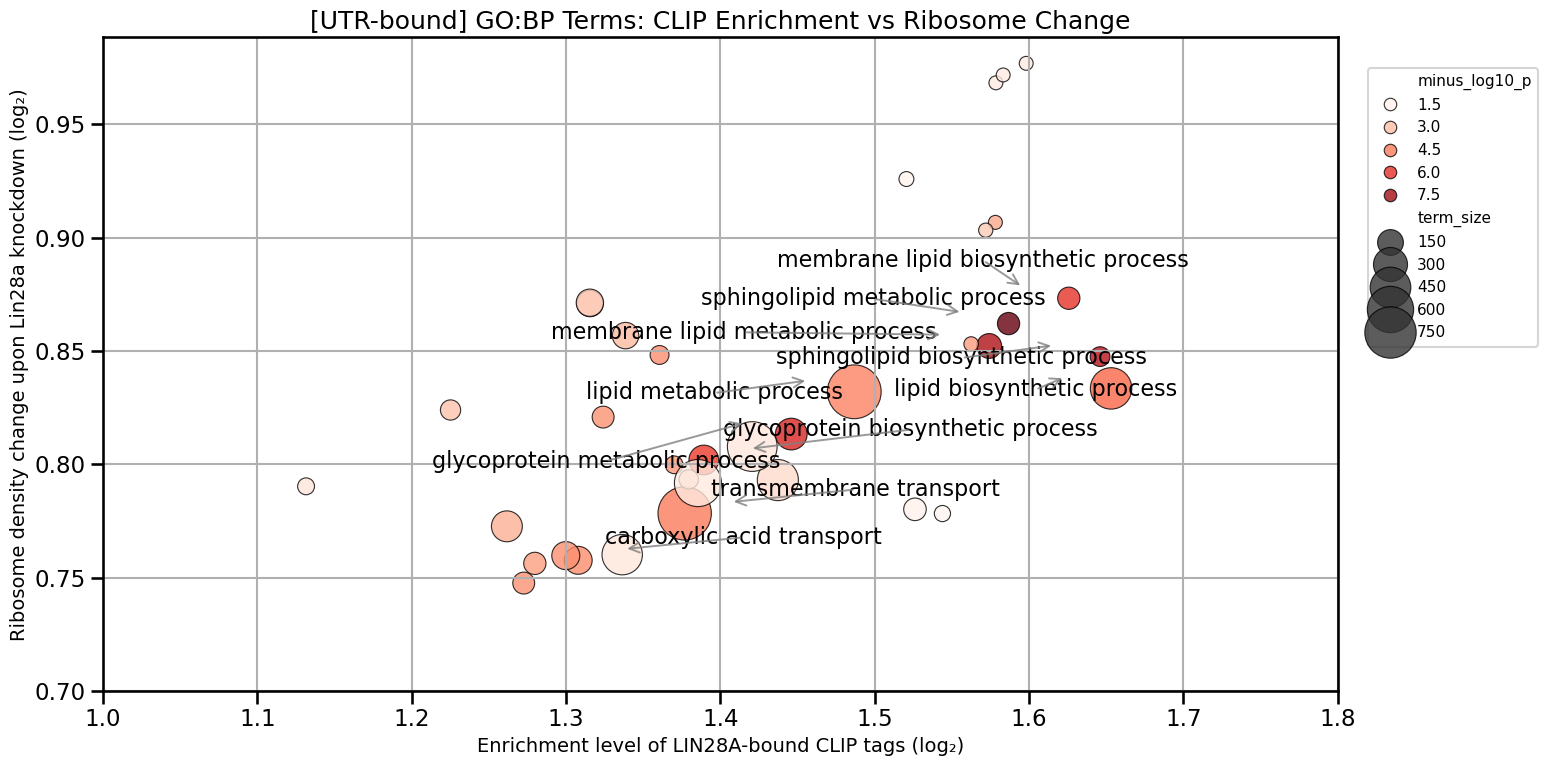

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import numpy as np

# jitter 적용
plot_df_jittered = bp_plot_df.copy()
np.random.seed(42)
jitter_strength = 0.008
plot_df_jittered['avg_clip_jitter'] = plot_df_jittered['avg_clip'] + np.random.normal(0, jitter_strength, len(plot_df_jittered))
plot_df_jittered['avg_ribo_jitter'] = plot_df_jittered['avg_ribo'] + np.random.normal(0, jitter_strength, len(plot_df_jittered))

# plot
plt.figure(figsize=(14, 8))
sns.set_context("talk")

ax = sns.scatterplot(
    data=plot_df_jittered,
    x='avg_clip_jitter',
    y='avg_ribo_jitter',
    size='term_size',
    hue='minus_log10_p',
    palette='Reds',
    sizes=(100, 1500),
    edgecolor='k',
    alpha=0.8
)

# label
labeled_df = plot_df_jittered.nsmallest(10, 'p_value')
texts = []

for _, row in labeled_df.iterrows():
    offset_x = -0.03 if row['avg_clip_jitter'] > plot_df_jittered['avg_clip_jitter'].mean() else 0.03
    offset_y = 0.005
    ha = 'right' if offset_x < 0 else 'left'

    texts.append(plt.text(
        row['avg_clip_jitter'] + offset_x,
        row['avg_ribo_jitter'] + offset_y,
        row['term'],
        fontsize=16,
        fontweight='medium',
        alpha=1.0,
        ha=ha
    ))

adjust_text(
    texts,
    only_move={'points': 'xy', 'text': 'xy'},
    arrowprops=dict(
        arrowstyle='->',
        color='gray',
        lw=1.4,
        mutation_scale=18,
        alpha=0.8
    ),
    expand_points=(1.5, 1.5),
    expand_text=(4.0, 4.0),
    force_text=(2.0, 2.0),
    force_points=(0.6, 0.6)
)

plt.title('[UTR-bound] GO:BP Terms: CLIP Enrichment vs Ribosome Change', fontsize=18)
plt.xlabel('Enrichment level of LIN28A-bound CLIP tags (log₂)', fontsize=14)
plt.ylabel('Ribosome density change upon Lin28a knockdown (log₂)', fontsize=14)
plt.ylim(0.7, None)
plt.xlim(1, 1.8)
plt.grid(True)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=2, fontsize=11, title_fontsize=13)
plt.show()




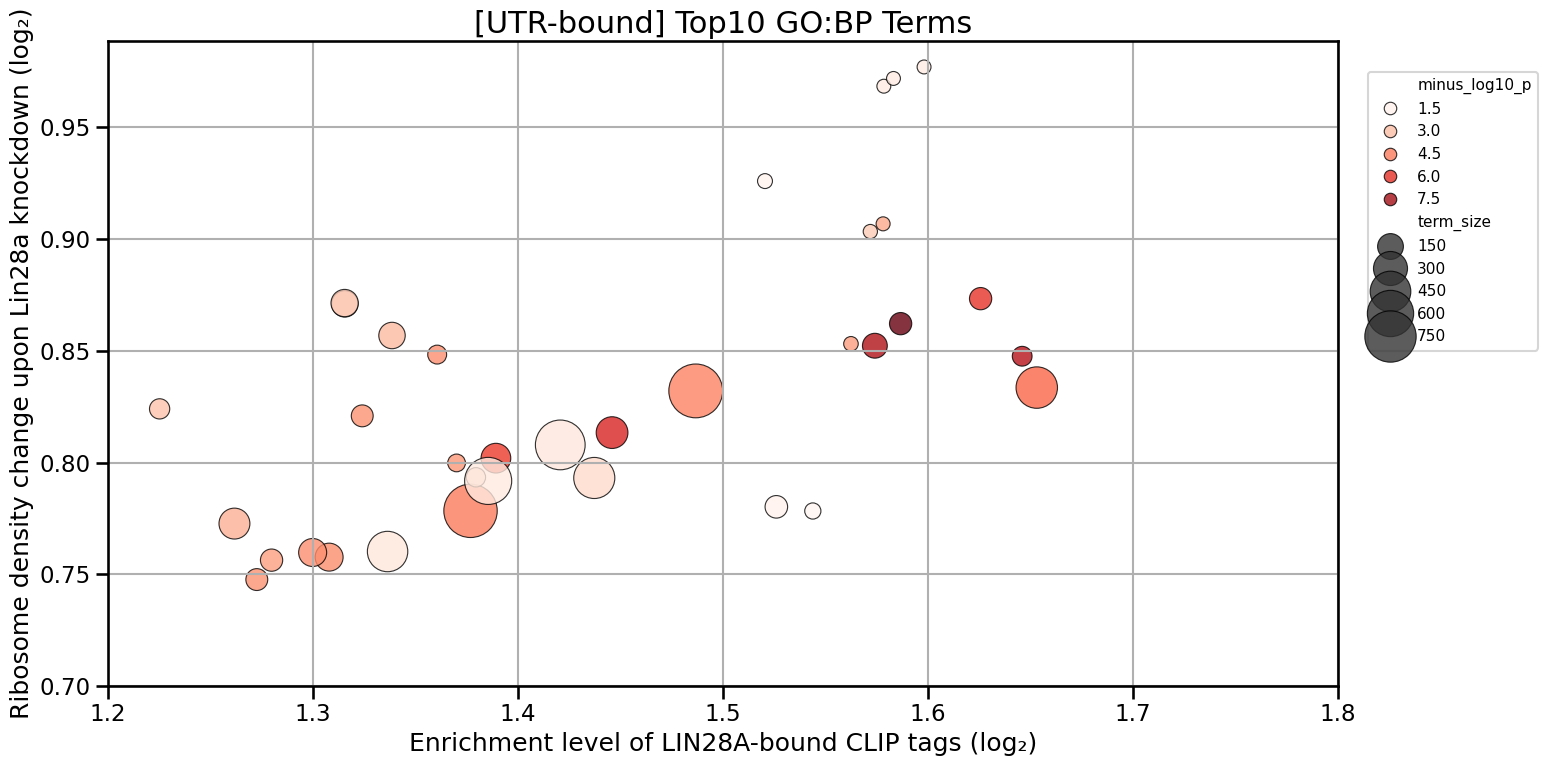

In [193]:

import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text  # 설치 필요: pip install adjustText
import numpy as np

# 1. GO:BP 필터
bp_terms = res_utr[res_utr['source'] == 'GO:BP'].copy()

# 2. gene list dictionary
bp_go_term_genes = {}
for i, row in bp_terms.iterrows():
    gene_list = row['intersections']
    if isinstance(gene_list, list):
        bp_go_term_genes[row['name']] = [g.strip() for g in gene_list]

# 3. 평균값 계산
plot_data = []
for term, gene_list in bp_go_term_genes.items():
    valid_genes = list(set(gene_list) & set(clip_df_2.index) & set(ribo_df_2.index))
    if len(valid_genes) == 0:
        continue

    avg_clip = clip_df_2.loc[valid_genes, 'clip_enrichment_log2'].mean()
    avg_ribo = ribo_df_2.loc[valid_genes, 'rden_change_log2'].mean()
    p_val = bp_terms[bp_terms['name'] == term]['p_value'].values[0]
    term_size = bp_terms[bp_terms['name'] == term]['term_size'].values[0]

    plot_data.append({
        'term': term,
        'avg_clip': avg_clip,
        'avg_ribo': avg_ribo,
        'term_size': term_size,
        'p_value': p_val,
        'minus_log10_p': -np.log10(p_val)
    })

bp_plot_df = pd.DataFrame(plot_data)
bp_plot_df = bp_plot_df[bp_plot_df['term_size'] < 1000]  # 예: 5000 이하만 표시


# jitter 적용
plot_df_jittered = bp_plot_df.copy()
np.random.seed(42)
jitter_strength = 0.008
plot_df_jittered['avg_clip_jitter'] = plot_df_jittered['avg_clip'] + np.random.normal(0, jitter_strength, len(plot_df_jittered))
plot_df_jittered['avg_ribo_jitter'] = plot_df_jittered['avg_ribo'] + np.random.normal(0, jitter_strength, len(plot_df_jittered))

# plot
plt.figure(figsize=(14, 8))
sns.set_context("talk")

ax = sns.scatterplot(
    data=plot_df_jittered,
    x='avg_clip_jitter',
    y='avg_ribo_jitter',
    size='term_size',
    hue='minus_log10_p',
    palette='Reds',
    sizes=(100, 1500),
    edgecolor='k',
    alpha=0.8
)

# label
labeled_df = plot_df_jittered.nsmallest(10, 'p_value')
texts = []

#for _, row in labeled_df.iterrows():
    #offset_x = -0.03 if row['avg_clip_jitter'] > plot_df_jittered['avg_clip_jitter'].mean() else 0.03
    #offset_y = 0.005
    #ha = 'right' if offset_x < 0 else 'left'

    #texts.append(plt.text(
        #row['avg_clip_jitter'] + offset_x,
        #row['avg_ribo_jitter'] + offset_y,
        #row['term'],
        #fontsize=16,
        #fontweight='medium',
        #alpha=1.0,
        #ha=ha
    #))

#adjust_text(
    #texts,
    #only_move={'points': 'xy', 'text': 'xy'},
    #arrowprops=dict(
        #arrowstyle='->',
        #color='gray',
        #lw=1.4,
        #mutation_scale=18,
        #alpha=0.8
    #),
    #expand_points=(1.5, 1.5),
    #expand_text=(5.0, 5.0),
    #force_text=(2.0, 2.0),
    #force_points=(0.6, 0.6)
#)

plt.title('[UTR-bound] Top10 GO:BP Terms', fontsize=22)
plt.xlabel('Enrichment level of LIN28A-bound CLIP tags (log₂)', fontsize=18)
plt.ylabel('Ribosome density change upon Lin28a knockdown (log₂)', fontsize=18)
plt.ylim(0.7, None)
plt.xlim(1.2, 1.8)
plt.grid(True)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=2, fontsize=11, title_fontsize=13)
plt.show()

2. CDS-bound (Top10 GO term)

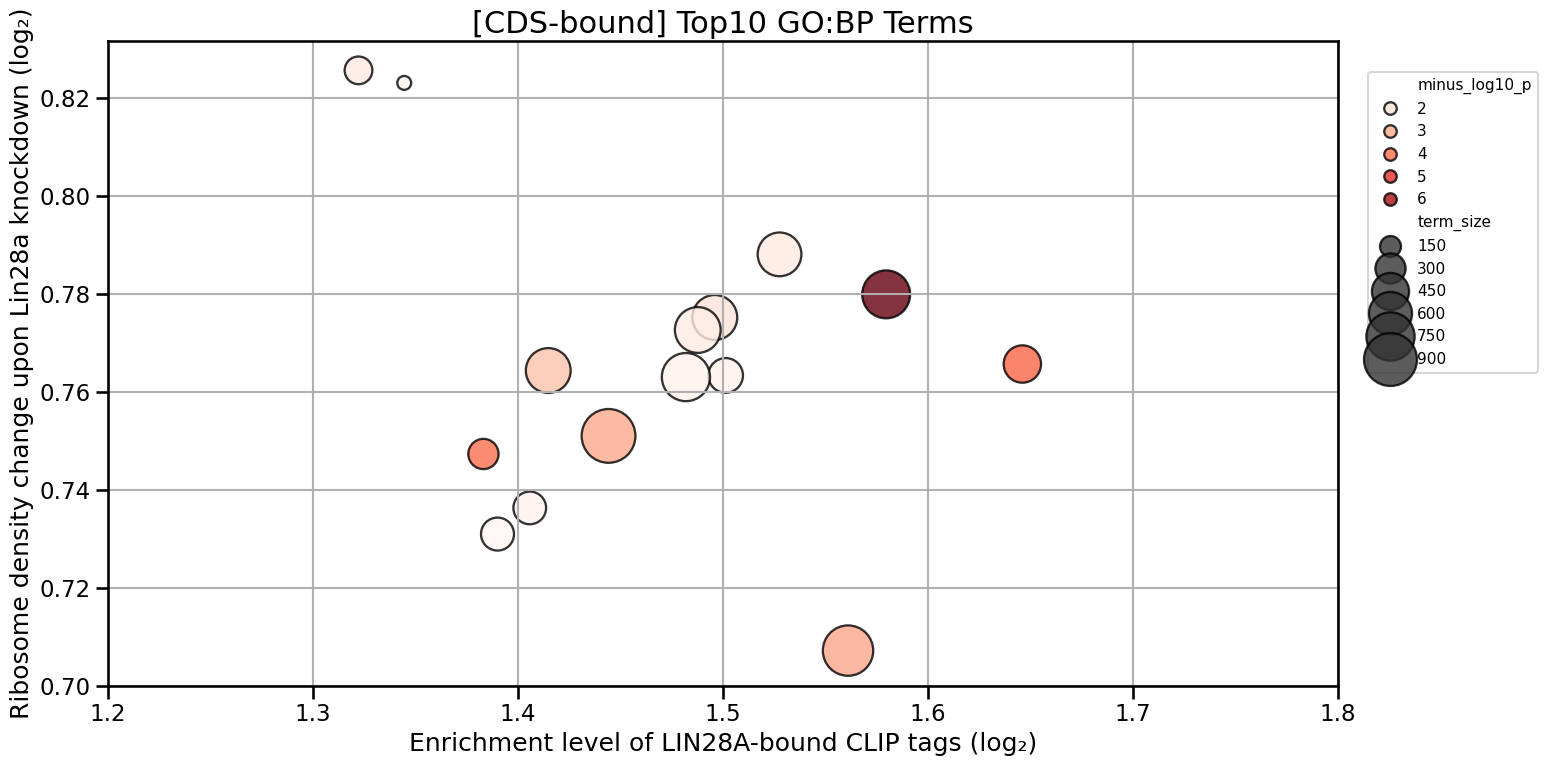

In [194]:

import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text  # 설치 필요: pip install adjustText
import numpy as np

# 1. GO:BP 필터
bp_terms = res_cds[res_cds['source'] == 'GO:BP'].copy()

# 2. gene list dictionary
bp_go_term_genes = {}
for i, row in bp_terms.iterrows():
    gene_list = row['intersections']
    if isinstance(gene_list, list):
        bp_go_term_genes[row['name']] = [g.strip() for g in gene_list]

# 3. 평균값 계산
plot_data = []
for term, gene_list in bp_go_term_genes.items():
    valid_genes = list(set(gene_list) & set(clip_df.index) & set(ribo_df.index))
    if len(valid_genes) == 0:
        continue

    avg_clip = clip_df.loc[valid_genes, 'clip_enrichment_log2'].mean()
    avg_ribo = ribo_df.loc[valid_genes, 'rden_change_log2'].mean()
    p_val = bp_terms[bp_terms['name'] == term]['p_value'].values[0]
    term_size = bp_terms[bp_terms['name'] == term]['term_size'].values[0]

    plot_data.append({
        'term': term,
        'avg_clip': avg_clip,
        'avg_ribo': avg_ribo,
        'term_size': term_size,
        'p_value': p_val,
        'minus_log10_p': -np.log10(p_val)
    })

bp_plot_df = pd.DataFrame(plot_data)
bp_plot_df = bp_plot_df[bp_plot_df['term_size'] < 1000]  # 예: 5000 이하만 표시


# jitter 적용
plot_df_jittered = bp_plot_df.copy()
np.random.seed(42)
jitter_strength = 0.008
plot_df_jittered['avg_clip_jitter'] = plot_df_jittered['avg_clip'] + np.random.normal(0, jitter_strength, len(plot_df_jittered))
plot_df_jittered['avg_ribo_jitter'] = plot_df_jittered['avg_ribo'] + np.random.normal(0, jitter_strength, len(plot_df_jittered))

# plot
plt.figure(figsize=(14, 8))
sns.set_context("talk")

ax = sns.scatterplot(
    data=plot_df_jittered,
    x='avg_clip_jitter',
    y='avg_ribo_jitter',
    size='term_size',
    hue='minus_log10_p',
    palette='Reds',
    sizes=(100, 1500),
    edgecolor='k',
    alpha=0.8
)

# label
labeled_df = plot_df_jittered.nsmallest(10, 'p_value')
texts = []

#for _, row in labeled_df.iterrows():
    #offset_x = -0.03 if row['avg_clip_jitter'] > plot_df_jittered['avg_clip_jitter'].mean() else 0.03
    #offset_y = 0.005
    #ha = 'right' if offset_x < 0 else 'left'

    #texts.append(plt.text(
        #row['avg_clip_jitter'] + offset_x,
        #row['avg_ribo_jitter'] + offset_y,
        #row['term'],
        #fontsize=16,
        #fontweight='medium',
        #alpha=1.0,
        #ha=ha
    #))

#adjust_text(
    #texts,
    #only_move={'points': 'xy', 'text': 'xy'},
    #arrowprops=dict(
        #arrowstyle='->',
        #color='gray',
        #lw=1.4,
        #mutation_scale=18,
        #alpha=0.8
    #),
    #expand_points=(1.5, 1.5),
    #expand_text=(8.0, 8.0),
    #force_text=(2.0, 2.0),
    #force_points=(0.6, 0.6)
#)

plt.title('[CDS-bound] Top10 GO:BP Terms', fontsize=22)
plt.xlabel('Enrichment level of LIN28A-bound CLIP tags (log₂)', fontsize=18)
plt.ylabel('Ribosome density change upon Lin28a knockdown (log₂)', fontsize=18)
plt.ylim(0.7, None)
plt.xlim(1.2, 1.8)
plt.grid(True)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=2, fontsize=11, title_fontsize=13)
plt.show()